<a href="https://colab.research.google.com/github/Sambradshaw19011/CSE-450/blob/main/starter_housing_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!pip install scikit-learn==1.5.2

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/operations/check.py", line 101, in check_install_conflicts
    package_set, _ = create_package_set_from_installed()
              

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

housing = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv')
housing.head()
housing["neighborhood"] = housing["id"].astype(str).str[:6]

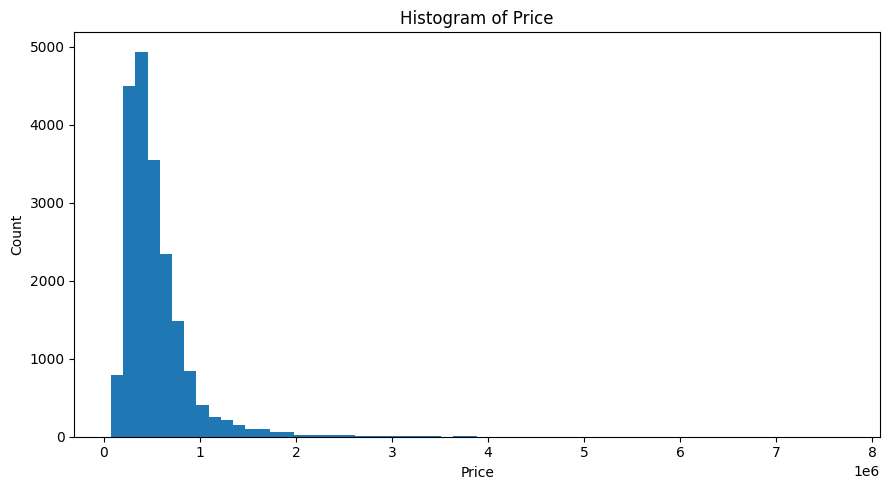

In [22]:
#histogram of price
plt.figure(figsize=(9, 5))
plt.hist(housing["price"], bins=60)
plt.title("Histogram of Price")
plt.xlabel("Price")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

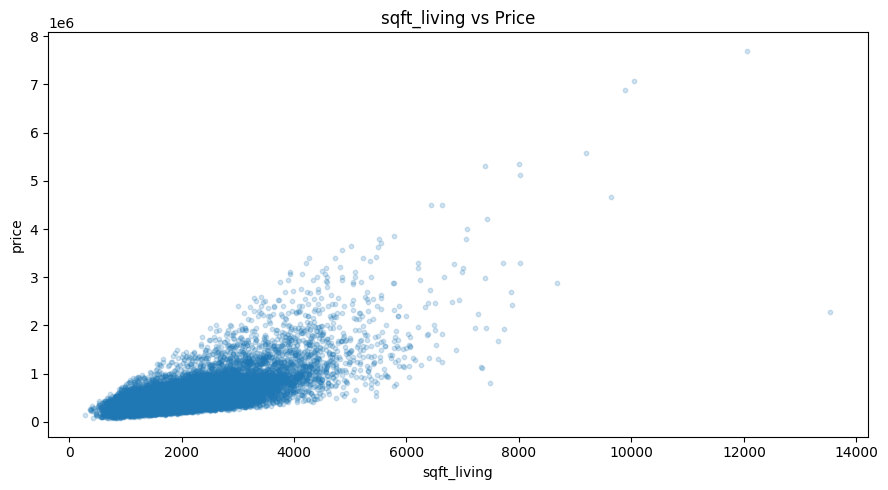

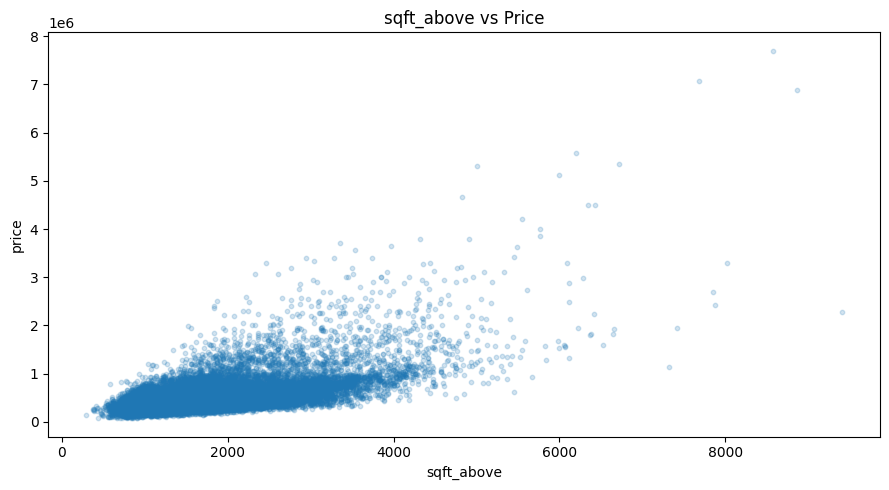

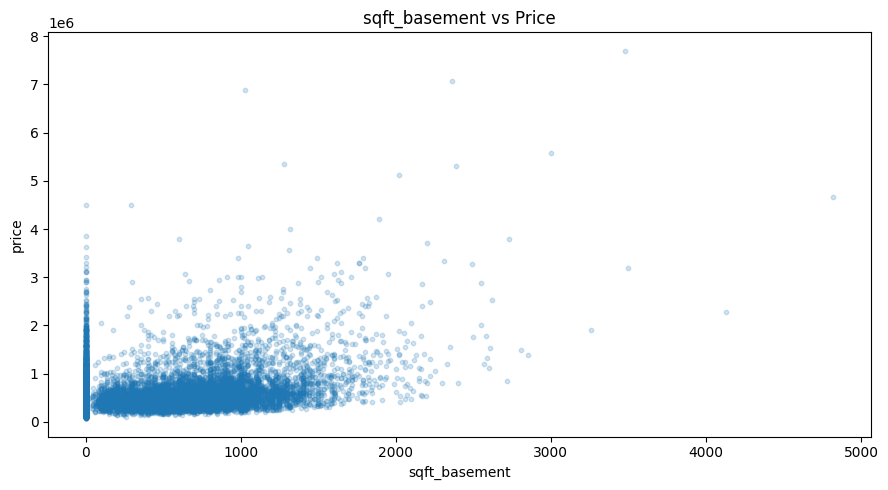

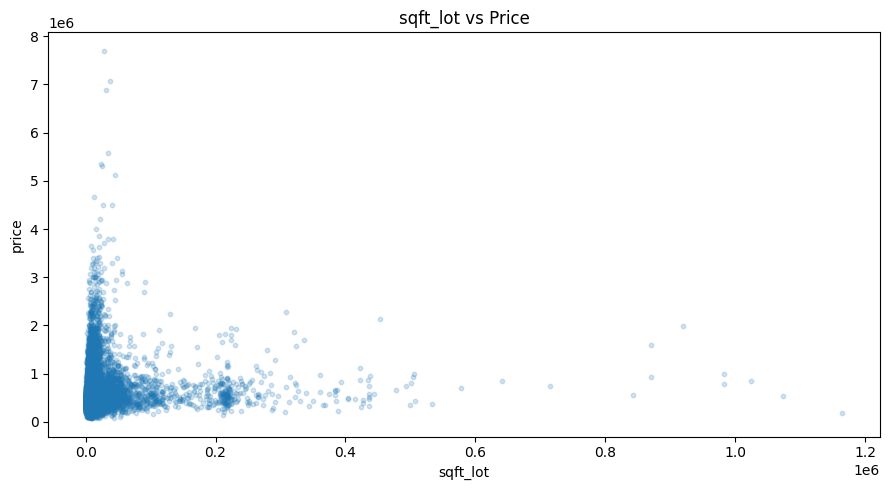

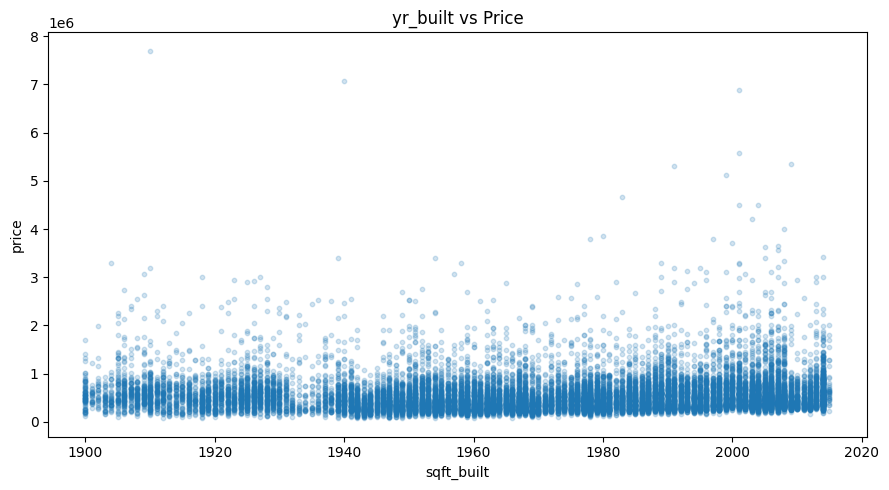

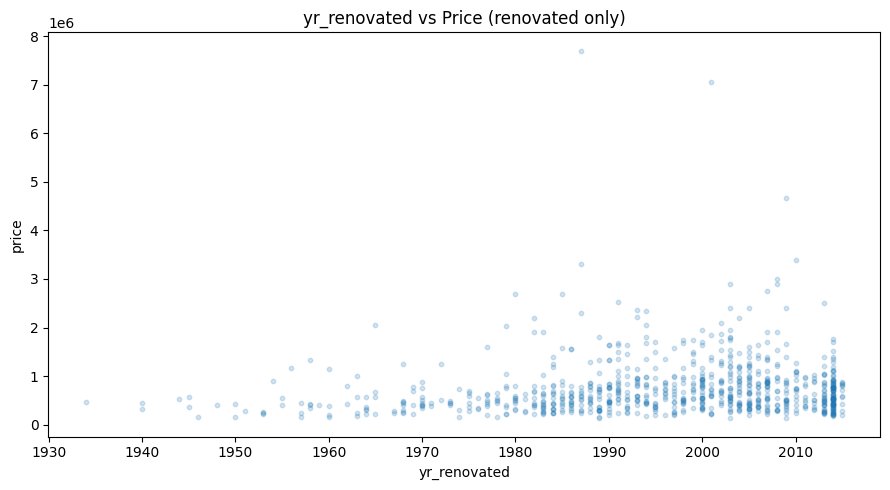

In [23]:
#various scatter plots
plt.figure(figsize=(9, 5))
plt.scatter(housing["sqft_living"], housing["price"], alpha=0.2, s=10)
plt.title("sqft_living vs Price")
plt.xlabel("sqft_living")
plt.ylabel("price")
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 5))
plt.scatter(housing["sqft_above"], housing["price"], alpha=0.2, s=10)
plt.title("sqft_above vs Price")
plt.xlabel("sqft_above")
plt.ylabel("price")
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 5))
plt.scatter(housing["sqft_basement"], housing["price"], alpha=0.2, s=10)
plt.title("sqft_basement vs Price")
plt.xlabel("sqft_basement")
plt.ylabel("price")
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 5))
plt.scatter(housing["sqft_lot"], housing["price"], alpha=0.2, s=10)
plt.title("sqft_lot vs Price")
plt.xlabel("sqft_lot")
plt.ylabel("price")
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 5))
plt.scatter(housing["yr_built"], housing["price"], alpha=0.2, s=10)
plt.title("yr_built vs Price")
plt.xlabel("sqft_built")
plt.ylabel("price")
plt.tight_layout()
plt.show()

filtered = housing[housing["yr_renovated"] != 0]

plt.figure(figsize=(9, 5))
plt.scatter(filtered["yr_renovated"], filtered["price"], alpha=0.2, s=10)
plt.title("yr_renovated vs Price (renovated only)")
plt.xlabel("yr_renovated")
plt.ylabel("price")
plt.tight_layout()
plt.show()

In [ ]:
col = "grade"
df_box = housing.dropna(subset=[col, "price"]).copy()

grades = np.sort(df_box[col].unique())
data = [df_box.loc[df_box[col] == g, "price"].values for g in grades]

plt.figure(figsize=(10, 5))
plt.boxplot(data, labels=grades, showfliers=False)
plt.title("Price by Grade (outliers hidden)")
plt.xlabel("grade")
plt.ylabel("price")
plt.tight_layout()
plt.show()


In [ ]:
col = "waterfront"
df_box = housing.dropna(subset=[col, "price"]).copy()

cats = np.sort(df_box[col].unique())
data = [df_box.loc[df_box[col] == c, "price"].values for c in cats]

plt.figure(figsize=(7, 5))
plt.boxplot(data, labels=cats, showfliers=False)
plt.title("Price by Waterfront (outliers hidden)")
plt.xlabel("waterfront (0=no, 1=yes)")
plt.ylabel("price")
plt.tight_layout()
plt.show()


In [ ]:
# Keep numeric columns only
num_df = housing.select_dtypes(include=[np.number]).copy()

# Optionally remove columns you don't want in correlation (like ids)
for maybe in ["id"]:
    if maybe in num_df.columns:
        num_df = num_df.drop(columns=[maybe])

corr = num_df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
plt.imshow(corr, aspect="auto")
plt.colorbar(label="Correlation")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation Heatmap (Numeric Features)")
plt.tight_layout()
plt.show()


/tmp/ipython-input-4293808809.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=neighborhoods, showfliers=False)


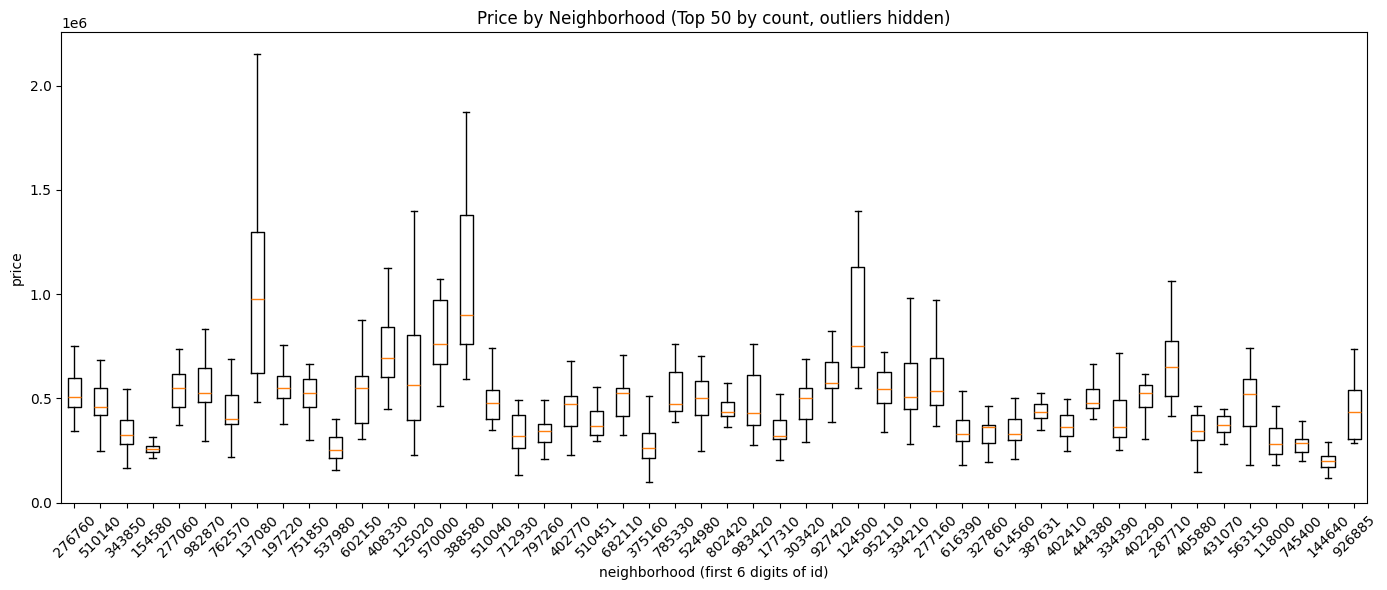

In [24]:
# Drop rows missing what we need
housing_nb = housing.dropna(subset=["neighborhood", "price"]).copy()

top_n = 50

top_neighborhoods = housing_nb["neighborhood"].value_counts().head(top_n).index
df_top = housing_nb[housing_nb["neighborhood"].isin(top_neighborhoods)].copy()

# Keep neighborhoods ordered by frequency (most common first)
neighborhoods = list(top_neighborhoods)
data = [df_top.loc[df_top["neighborhood"] == n, "price"].values for n in neighborhoods]

plt.figure(figsize=(14, 6))
plt.boxplot(data, labels=neighborhoods, showfliers=False)
plt.title(f"Price by Neighborhood (Top {top_n} by count, outliers hidden)")
plt.xlabel("neighborhood (first 6 digits of id)")
plt.ylabel("price")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [32]:
X = pd.get_dummies(housing.drop(columns=["price", "id"]), drop_first=True)

# Target (log transform)
y = np.log1p(housing["price"])

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Model
model = XGBRegressor(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5,
    reg_alpha=0.0,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

# Fit
model.fit(X_train, y_train)

# Predict (log units)
pred_log = model.predict(X_test)

# Convert back to dollars
pred_price = np.expm1(pred_log)
y_test_price = np.expm1(y_test)

# Metrics in dollars
rmse = root_mean_squared_error(y_test_price, pred_price)
r2 = r2_score(y_test_price, pred_price)

print("RMSE (dollars):", rmse)
print("R^2 (dollars):", r2)

RMSE (dollars): 127134.51896528284
R^2 (dollars): 0.8928301214907959


In [27]:

importances = model.feature_importances_
feature_names = X.columns

fi = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print(fi.head(30).to_string(index=False))

             feature  importance
               grade    0.289085
         sqft_living    0.096641
                 lat    0.048631
          waterfront    0.047094
                long    0.030909
                view    0.022469
       sqft_living15    0.018459
            yr_built    0.016211
 neighborhood_111800    0.009600
             zipcode    0.009505
 neighborhood_607280    0.008609
           bathrooms    0.008117
 neighborhood_252504    0.007298
 neighborhood_896480    0.006139
 neighborhood_947120    0.006031
date_20140624T000000    0.005334
 neighborhood_413950    0.004735
 neighborhood_262408    0.004721
        yr_renovated    0.004707
 neighborhood_388580    0.004301
 neighborhood_980810    0.004263
date_20141111T000000    0.004229
          sqft_lot15    0.004225
            sqft_lot    0.004135
 neighborhood_376050    0.004090
 neighborhood_980870    0.003956
          sqft_above    0.003858
           condition    0.003755
 neighborhood_438570    0.003353
 neighborh